In [3]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Model
from keras.models import model_from_json
from keras import regularizers
import datetime
import time
import requests as req
import json
import pandas as pd
import pickle
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Parameters

In [4]:
startdate="01/01/2015"
window_length = 10
encoding_dim = 3
epochs = 100
test_samples = 2000

## Utils

In [5]:
def mkdate(ts):
    return datetime.datetime.fromtimestamp(
        int(ts)
    ).strftime('%Y-%m-%d')

def plot_examples(stock_input, stock_decoded):
    n = 10  
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(list(np.arange(0, test_samples, 200))):
        # display original
        ax = plt.subplot(2, n, i + 1)
        if i == 0:
            ax.set_ylabel("Input", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_input[idx])
        ax.get_xaxis().set_visible(False)
        

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        if i == 0:
            ax.set_ylabel("Output", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_decoded[idx])
        ax.get_xaxis().set_visible(False)
        
        
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")

## Datasets retrieval & transformation

In [6]:
# get data
start_timestamp = time.mktime(datetime.datetime.strptime(startdate, "%d/%m/%Y").timetuple())
end_timestamp = int(time.time())
one_week = 3600*24*7 # s
one_day = 3600*24 # s
weeks = list(np.arange(start_timestamp, end_timestamp, one_week))
days_recorded = (datetime.datetime.fromtimestamp(end_timestamp)-datetime.datetime.fromtimestamp(start_timestamp)).days
print("days_recorded ",days_recorded)
data = []
if not os.path.isfile("data.pickle"):
    s = req.Session()
    r = s.get("https://www.coindesk.com/price/")
    for i in range(1, len(weeks)):
        start_weekday = mkdate(weeks[i-1])
        end_weekday = mkdate(weeks[i]-one_day)
        print(start_weekday, end_weekday)
        r = s.get("https://api.coindesk.com/charts/data?data=close&startdate={}&enddate={}&exchanges=bpi&dev=1&index=USD".format(start_weekday, end_weekday))
        ans = json.loads(r.text.replace("cb(", "").replace(");",""))["bpi"]
        ans.sort(key=lambda x: x[0])
        for pricepoint in ans:
            if pricepoint[0]/1000 >= weeks[i-1] and pricepoint[0]/1000 < (weeks[i]-one_day):
                data.append([int(pricepoint[0]/1000), pricepoint[1]])
                
    pickle.dump(data, open("./data.pickle", "wb"))
else:
    data = pickle.load(open("./data.pickle", "rb"))

df = pd.DataFrame(np.array(data)[:,1], columns=['price'])
df['pct_change'] = df.price.pct_change()
df['log_ret'] = np.log(df.price) - np.log(df.price.shift(1))

scaler = MinMaxScaler()
x_train_nonscaled = np.array([df['log_ret'].values[i-window_length:i].reshape(-1, 1) for i in tqdm(range(window_length+1,len(df['log_ret'])))])
x_train = np.array([scaler.fit_transform(df['log_ret'].values[i-window_length:i].reshape(-1, 1)) for i in tqdm(range(window_length+1,len(df['log_ret'])))])

x_test = x_train[-test_samples:]
x_train = x_train[:-test_samples]

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

days_recorded  2041


100%|██████████████████████████████████████████████████████████████████████████| 40293/40293 [00:14<00:00, 2714.75it/s]


In [10]:
x_test.shape

(2000, 10, 1)

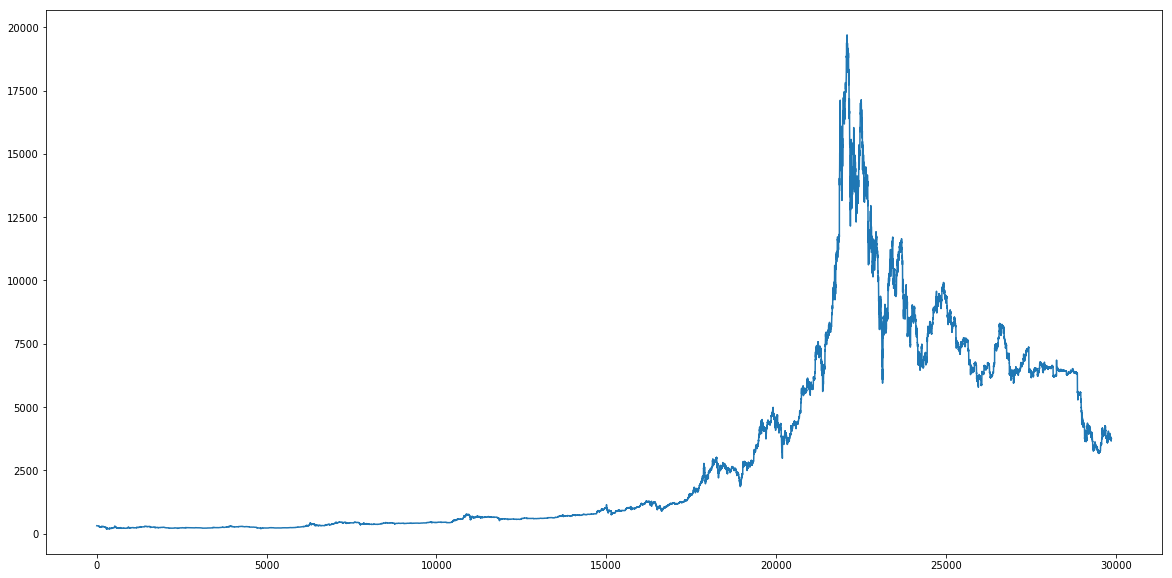

In [49]:
plt.figure(figsize=(20,10))
plt.plot(np.array(data)[:,1])

In [50]:
print("Percentage of test data: {}%".format((test_samples/len(x_train))*100))

Percentage of test data: 7.178493234270126%


## Simple feed-forward autoencoder

In [41]:
x_train_simple = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_simple = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# this is our input placeholder
input_window = Input(shape=(window_length,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_window)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(window_length, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_window, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_window, encoded)


autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_simple, x_train_simple,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_simple, x_test_simple))

decoded_stocks = autoencoder.predict(x_test_simple)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 33        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                40        
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________
Train on 27861 samples, validate on 2000 samples
Epoch 1/100
27861/27861 [==============================] - 0s 11us/step - loss: 0.6902 - val_loss: 0.6879
Epoch 2/100
27861/27861 [==============================] - 0s 4us/step - loss: 0.6874 - val_loss: 0.6855

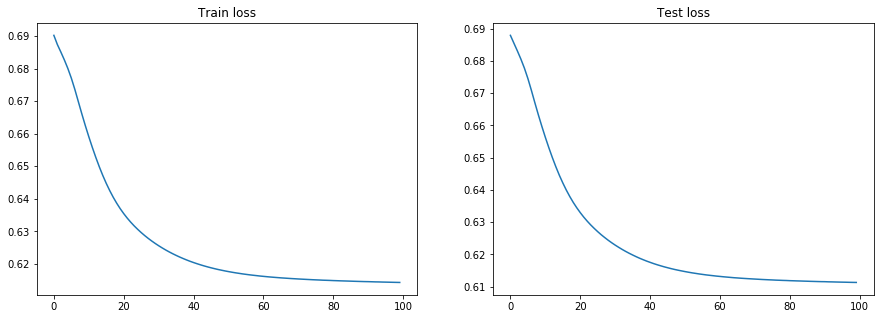

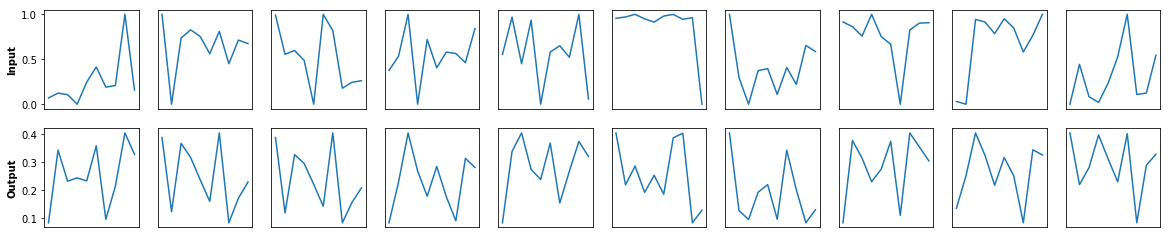

In [59]:
plot_history(history)
plot_examples(x_test_simple, decoded_stocks)

## Deep autoencoder

In [76]:
x_train_deep = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_deep = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

input_window = Input(shape=(window_length,))

x = Dense(6, activation='relu')(input_window)
x = BatchNormalization()(x)
encoded = Dense(encoding_dim, activation='relu')(x)
# "decoded" is the lossy reconstruction of the input

x = Dense(6, activation='relu')(encoded)
x = BatchNormalization()(x)
decoded = Dense(window_length, activation='sigmoid')(x)

# this model maps an input to its reconstruction
autoencoder = Model(input_window, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_window, encoded)

autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_deep, x_train_deep,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_deep, x_test_deep))

decoded_stocks = autoencoder.predict(x_test_deep)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 66        
_________________________________________________________________
batch_normalization_5 (Batch (None, 6)                 24        
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 21        
_________________________________________________________________
dense_17 (Dense)             (None, 6)                 24        
_________________________________________________________________
batch_normalization_6 (Batch (None, 6)                 24        
_________________________________________________________________
dense_18 (Dense)             (None, 10)                70        
Total para

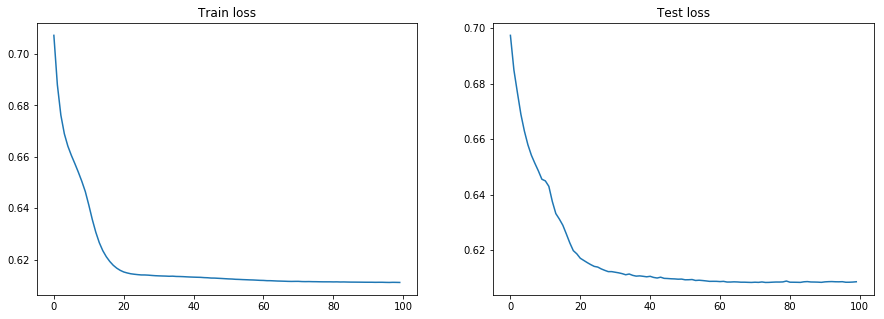

In [77]:
plot_history(history)

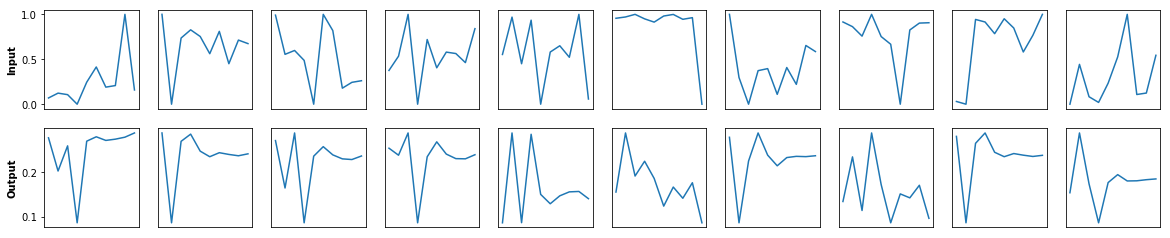

In [78]:
plot_examples(x_test_deep, decoded_stocks)

## 1D Convolutional autoencoder

In [63]:
input_window = Input(shape=(window_length,1))
x = Conv1D(16, 3, activation="relu", padding="same")(input_window) # 10 dims
#x = BatchNormalization()(x)
x = MaxPooling1D(2, padding="same")(x) # 5 dims
x = Conv1D(1, 3, activation="relu", padding="same")(x) # 5 dims
#x = BatchNormalization()(x)
encoded = MaxPooling1D(2, padding="same")(x) # 3 dims

encoder = Model(input_window, encoded)

# 3 dimensions in the encoded layer

x = Conv1D(1, 3, activation="relu", padding="same")(encoded) # 3 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 6 dims
x = Conv1D(16, 2, activation='relu')(x) # 5 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 10 dims
decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x) # 10 dims
autoencoder = Model(input_window, decoded)
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test, x_test))

decoded_stocks = autoencoder.predict(x_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 10, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 16)            64        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 16)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 1)              49        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 1)              0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3, 1)              4         
_________________________________________________________________
up_sampling1d_1 (UpSampling1 (None, 6, 1)              0         
__________

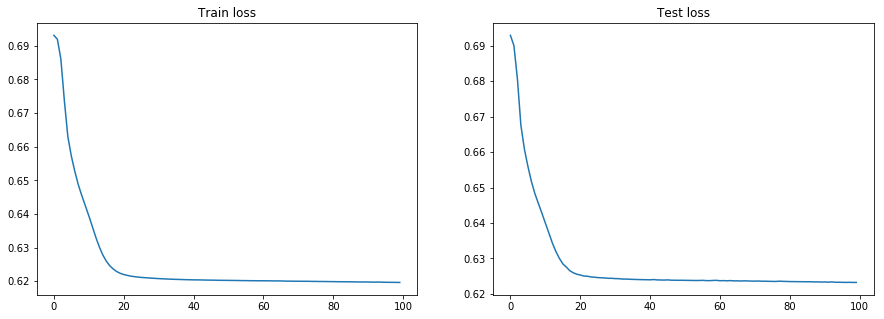

In [64]:
plot_history(history)

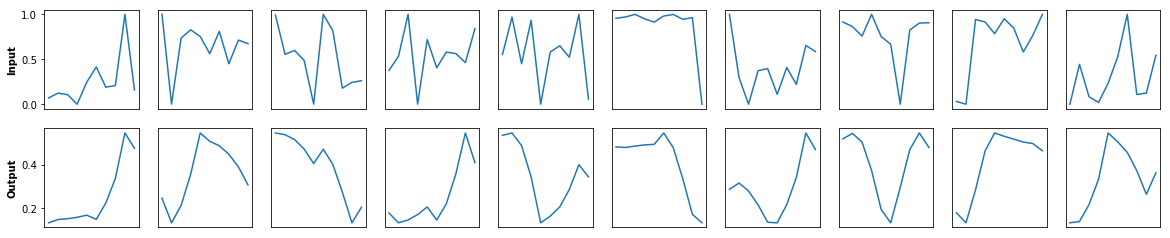

In [65]:
plot_examples(x_test_deep, decoded_stocks)

## LSTM (recurrent neural networks) autoencoder

In [79]:
inputs = Input(shape=(window_length, 1))
encoded = LSTM(encoding_dim)(inputs)

decoded = RepeatVector(window_length)(encoded)
decoded = LSTM(1, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)
sequence_autoencoder.summary()

sequence_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = sequence_autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test, x_test))

decoded_stocks = sequence_autoencoder.predict(x_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 10, 1)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 3)                 60        
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 10, 3)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 1)             20        
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________
Train on 27861 samples, validate on 2000 samples
Epoch 1/100
27861/27861 [==============================] - 3s 99us/step - loss: 1.0630 - val_loss: 0.9645

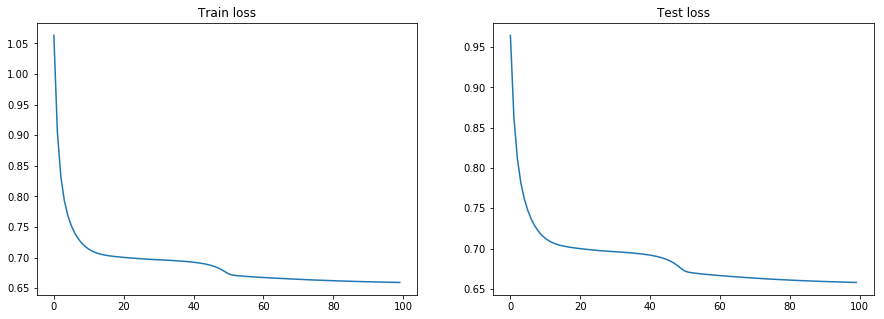

In [80]:
plot_history(history)

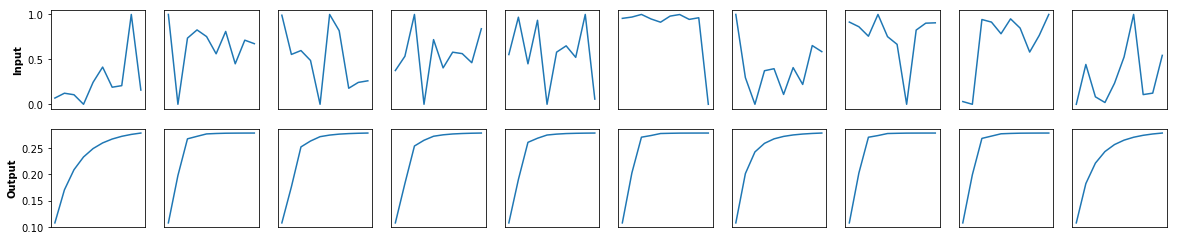

In [81]:
plot_examples(x_test, decoded_stocks)

## Simple AE + augmention with synthetic data

In [69]:
synthesized = []
required_nums = [0, 1]
optional_nums = list(np.arange(0.1, 0.9, 0.1))
for i in tqdm(range(100000)):
    combo = list(np.random.choice(optional_nums, 8))+required_nums
    np.random.shuffle(combo)
    synthesized.append(combo)

100%|██████████| 100000/100000 [00:02<00:00, 45049.00it/s]


In [70]:
x_train_simple = np.concatenate((x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))),synthesized))
x_test_simple = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


input_window = Input(shape=(window_length,))
encoded = Dense(encoding_dim, activation='relu')(input_window)
decoded = Dense(window_length, activation='sigmoid')(encoded)
autoencoder = Model(input_window, decoded)
encoder = Model(input_window, encoded)


autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_simple, x_train_simple,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_simple, x_test_simple))

decoded_stocks = autoencoder.predict(x_test_simple)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 33        
_________________________________________________________________
dense_10 (Dense)             (None, 10)                40        
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________
Train on 127861 samples, validate on 2000 samples
Epoch 1/100
127861/127861 [==============================] - 1s 8us/step - loss: 0.7057 - val_loss: 0.6930

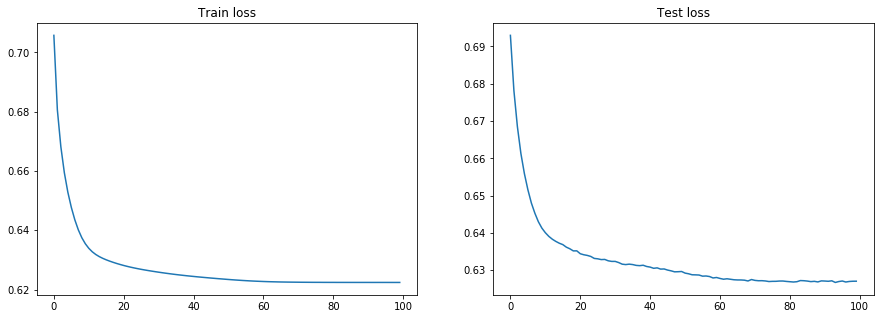

In [71]:
plot_history(history)

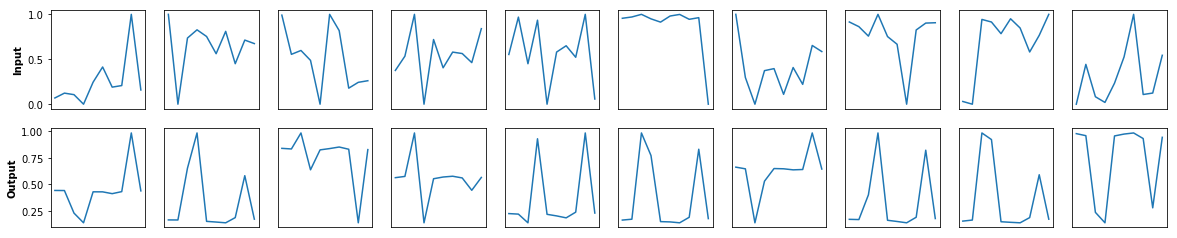

In [72]:
plot_examples(x_test_simple, decoded_stocks)

## Deep autoencoder + synthetic data

In [73]:
x_train_deep = np.concatenate((x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))),synthesized))
x_test_deep = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
input_window = Input(shape=(window_length,))

x = Dense(6, activation='relu')(input_window)
x = BatchNormalization()(x)
encoded = Dense(encoding_dim, activation='relu')(x)
x = Dense(6, activation='relu')(encoded)
x = BatchNormalization()(x)
decoded = Dense(window_length, activation='sigmoid')(x)
autoencoder = Model(input_window, decoded)

autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_deep, x_train_deep,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_deep, x_test_deep))

decoded_stocks = autoencoder.predict(x_test_deep)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 66        
_________________________________________________________________
batch_normalization_3 (Batch (None, 6)                 24        
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 21        
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 24        
_________________________________________________________________
batch_normalization_4 (Batch (None, 6)                 24        
_________________________________________________________________
dense_14 (Dense)             (None, 10)                70        
Total para

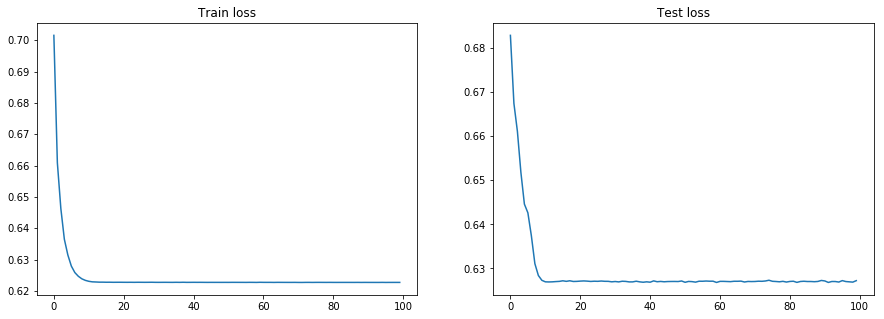

In [74]:
plot_history(history)

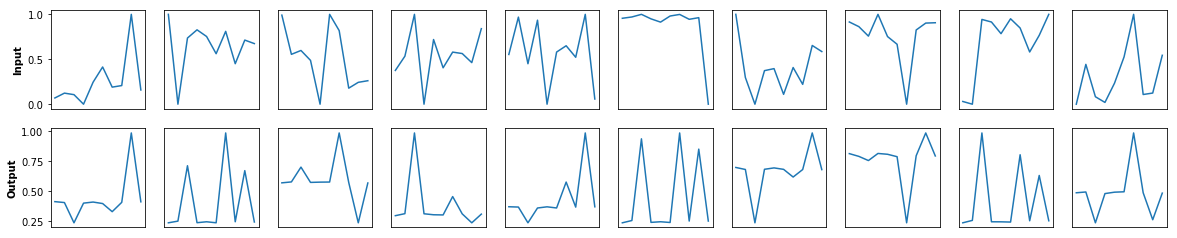

In [75]:
plot_examples(x_test_simple, decoded_stocks)